## Lattice dynamics - harmonic approximation
---

In this notebook we will perform a basic lattice dynamics calculation using *finite displacements* (or *direct*) method applied to the 3C-SiC crystal. The results are reasonably close to included experimental data - despite substantial shortcuts taken in calculation setup e.g.:
- low energy cutoff
- small reciprocal space sampling grids (2x2x2)
- very small supercell (just one  crystallographic unit cell)
- small number of displacements (just one all-atom displacement)

These shortcuts are dictated by the need to keep a reasonable execution time. The main reason for the acceptable accuracy of the results is a low number of electrons in the system and interatomic potentials which are fairly close to harmonic.

### Calculation setup

In [2]:
%pylab inline
import ase
import ase.io
from ase.build import bulk
from ase.calculators.abinit import Abinit
from ase import units as un
from elastic import get_pressure

# Utility functions
from tqdm.auto import tqdm
from scipy.integrate import simps

Populating the interactive namespace from numpy and matplotlib


In [3]:
def scan_param(cryst, param, start=0, stop=1, steps=7, 
               lista=None, log_scale=True, int_par=False):
    '''
    Scan a range of parameter param and plot 
    '''
    fi = lambda x: x
    fo = lambda x: x

    if lista is None:
        if log_scale :
            fi = log
            fo = exp
        lista = linspace(fi(start), fi(stop), steps)
    else :
        int_par=False
    
    dat = []
    vs = []
        
    for v in lista:
        print(f'{param}={fo(v)}: ', end='')
        if int_par:
            cryst.calc.set(**{param: int(fo(v))})
        else :
            cryst.calc.set(**{param: fo(v)})
        vs.append(fo(v))
        dat.append([cryst.get_potential_energy(),
                    cryst.get_stress()[:3].mean()])
        print(f'{dat[-1][0]:.3f} eV ; {dat[-1][1]/un.GPa:6.3f} GPa',)
    dat = array(dat).T
    return vs, dat

In [4]:
a = 4.38120844
prim = bulk('SiC', crystalstructure='zincblende', a=a, cubic=False)

In [5]:
def create_calculator(label, directory='work_08', ecut=350):
    return Abinit(label=label, directory=directory, v8_legacy_format=True,
              ecut= ecut,
              pps = 'pawxml', pawecutdg = 750, xc = 'GGA',
              toldfe=1.0e-6,
              diemac=12,
              nstep=20,
              kptopt=1,
              ngkpt=[2,2,2],
              nshiftk=1,
              shiftk=[[0.5, 0.5, 0.5]],
              chksymbreak=0,
              )

In [6]:
calc = create_calculator(label='SiC')
prim.set_calculator(calc)

In [7]:
print(f'  Energy:  {prim.get_potential_energy():.3f} eV')
print( '  Stress: [', 6*' %6.2f' % tuple(prim.get_stress()/un.GPa), '] GPa')
print(f'Pressure:     {get_pressure(prim.get_stress())/un.GPa:.3f} GPa')

  Energy:  -265.151 eV
  Stress: [   -0.26  -0.26  -0.26   0.00   0.00   0.00 ] GPa
Pressure:     0.260 GPa


### Convergence scan
---
This is a reminder that you should *always* perform convergence analysis of your calculations. You can skip this step by setting `Scan_Corvengence = False` if you already have done so.

In [8]:
Scan_Corvengence = True

ecut=299.99999999999994: -265.131 eV ;  0.770 GPa
ecut=326.66006663610074: -265.147 eV ;  0.057 GPa
ecut=355.6893304490063: -265.153 eV ; -0.303 GPa
ecut=387.29833462074157: -265.155 eV ; -0.453 GPa
ecut=421.7163326508744: -265.155 eV ; -0.457 GPa
ecut=459.19295108422267: -265.156 eV ; -0.434 GPa
ecut=499.99999999999983: -265.157 eV ; -0.424 GPa


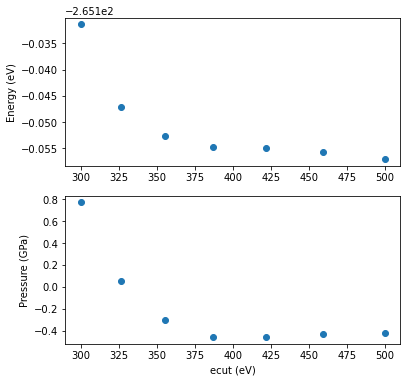

In [9]:
if Scan_Corvengence :
    ecut = prim.calc.parameters['ecut']
    ecuts, eres = scan_param(prim, 'ecut', 300, 500)

    figsize(6,6)
    subplot(211)
    plot(ecuts, eres[0], 'o')
    ylabel('Energy (eV)')
    subplot(212)
    plot(ecuts, eres[1]/un.GPa, 'o')
    ylabel('Pressure (GPa)')
    xlabel('ecut (eV)');
    prim.calc.set(ecut=ecut)

### Basic structure calculation

---


In [10]:
cryst = bulk('SiC', crystalstructure='zincblende', a=a, cubic=True)
cryst = ase.build.sort(cryst, tags=cryst.get_atomic_numbers())
cryst.set_calculator(create_calculator('SiC_UC'))

In [11]:
cryst.get_forces()

array([[ 0., -0., -0.],
       [ 0.,  0.,  0.],
       [-0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [-0.,  0.,  0.],
       [-0.,  0., -0.],
       [ 0., -0., -0.],
       [ 0., -0., -0.]])

### Generate displacements and calculate forces

---

In [12]:
dsp={}
N = 1
for n in range(N):
    dsp[n] = ase.Atoms(cryst)
    dsp[n].set_calculator(create_calculator(f'SiC_dsp_{n}'))
    dsp[n].rattle(stdev=0.01)

In [13]:
with open('work_08/DFSET', 'wt') as dfset:
    # Iterate over structures
    for n, s in tqdm(dsp.items()):
        # Write data to DFSET file
        savetxt(dfset,
                # Generate list of displacement - force records:
                # dx dy dz fx fy fz
                # for each atom and each structure
                # Units for ALAMODE: Bohr and Rydberg/Bohr !
                [list(x/un.Bohr)+list(f/(un.Rydberg/un.Bohr)) 
                    for x, f in zip(s.get_positions()-cryst.get_positions(), 
                                    s.get_forces()) ],
                fmt="%14.8f", 
                header=f'Sample: {n:5}  Energy: {s.get_potential_energy():.4f} eV')

  0%|          | 0/1 [00:00<?, ?it/s]

### Phonon calculation with ALAMODE

---

#### Generate remaining ALAMODE input files

In [14]:
!./make-am-files.py --help

Usage: make-am-files.py [OPTIONS] [ACTION]

  Generates gen/opt/phon/dos file depending on the ACTION: gen (default,
  generate displacements),  opt (find force matrices), phon (calculate
  phonons), dos (calculate dos).  The default values of parameters are
  enclosed in parethesis.

Options:
  -o, --order INTEGER  Approximation order (1)
  -p, --prefix TEXT    Prefix used in calculations (CRYST)
  -n, --name PATH      Supercell POSCAR file (SPOSCAR)
  -s, --scale FLOAT    Scale of the unit cell (1.0)
  -e, --evec INTEGER   Print eigenvectors (1)
  -m, --msd INTEGER    Print mean squere displacement (1)
  --c1 TEXT            First order interaction cutoff (None)
  --c2 TEXT            Second order interaction cutoff (10)
  --c3 TEXT            Third order interaction cutoff (10)
  -k, --kpath PATH     File with reciprocal space path
  -g, --grid TEXT      k-grid for dos calculation (10x10x10)
  -d, --ndat INTEGER   Number of data points used in fitting (All)
  -f, --dfset TEXT     Na

In [15]:
# Write supercell data in VASP format file
ase.io.write('work_08/POSCAR', cryst, vasp5=True, direct=True)

In [16]:
!./make-am-files.py -p 3C-SiC -n work_08/POSCAR opt > work_08/alm_fit.in

In [17]:
!./make-am-files.py -p 3C-SiC -n work_08/POSCAR \
    -k 3C-SiC.path -b 3 -c ../3C-SiC phon > work_08/alm_ph.in

In [18]:
!./make-am-files.py -p 3C-SiC -n work_08/POSCAR \
    -g 10x10x10 -b 3 -c ../3C-SiC dos > work_08/alm_dos.in

#### Run the fitting and phonon calculation

In [19]:
%%bash
(cd work_08
 
 # Fitting
 alm alm_fit.in > alm_fit.log
 tail alm_fit.log
 
 # Phonon dispersion
 anphon alm_ph.in > alm_ph.log
 tail alm_ph.log
 
 # Phonon density of states
 anphon alm_dos.in > alm_dos.log
 tail alm_dos.log
)


 -------------------------------------------------------------------

 The following files are created:

 Force constants in a human-readable format : 3C-SiC.fcs
 Input data for the phonon code ANPHON      : 3C-SiC.xml

 Job finished at Wed Apr 28 14:26:33 2021



 -----------------------------------------------------------------

 The following files are created: 
  3C-SiC.bands       : Phonon band structure
  3C-SiC.evec        : Eigenvector of all k points

 Job finished at Wed Apr 28 14:26:35 2021

 -----------------------------------------------------------------

 The following files are created: 
  3C-SiC.dos         : Phonon DOS and atom projected DOS
  3C-SiC.thermo      : Thermodynamic quantities
  3C-SiC.msd         : Mean-square-displacement (MSD)
  3C-SiC.evec        : Eigenvector of all k points

 Job finished at Wed Apr 28 14:27:01 2021



### Plot the results

---

#### Phonon dispersion relation

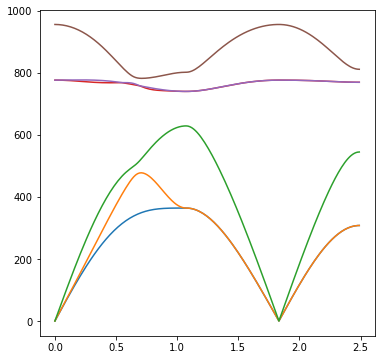

In [20]:
# Just simple plot
bnd = loadtxt('work_08/3C-SiC.bands').T
plot(bnd[0], bnd[1:].T);

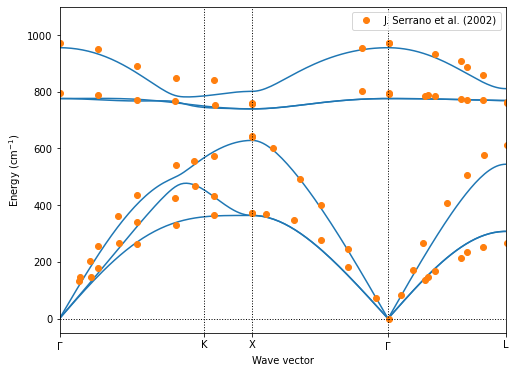

In [21]:
# Make it nice...
figsize(8,6)
fn = f'work_08/3C-SiC.bands'

# Read the metadata from the header
with open(fn, 'r') as df:
    for i, l in enumerate(df):
        if i==0:
            nm = [n.replace('G','$\\Gamma$') for n in l.split()[1:]]
        elif i==1:
            pos = [float(x) for x in l.split()[1:]]
        else :
            break
    pnts = [nm,pos]

# Load and plot the data
d = loadtxt(fn).T
plot(d[0], d[1:].T, color=f'C0', ls='-')

# Compare with experiment
ex = loadtxt('data/serrano.dat').T
plot(ex[0], ex[1], 'o', color='C1', label='J. Serrano et al. (2002)')
legend()

# Sugar-coating
xlim(pnts[1][0], pnts[1][-1])
ylim(bottom=-50, top=1100)
axhline(ls=":", lw=1, color='k')
gca().set_xticks(pnts[1])
gca().set_xticklabels(pnts[0])
for xx in pnts[1][1:-1]:
    axvline(xx, ls=':', lw=1, color='k')
    

ylabel('Energy (cm$^{-1}$)')
xlabel('Wave vector')

# Save it for posterity
savefig('SiC_phonons.pdf');

#### Phonon density of states

In [22]:
dos = loadtxt('work_08/3C-SiC.dos').T

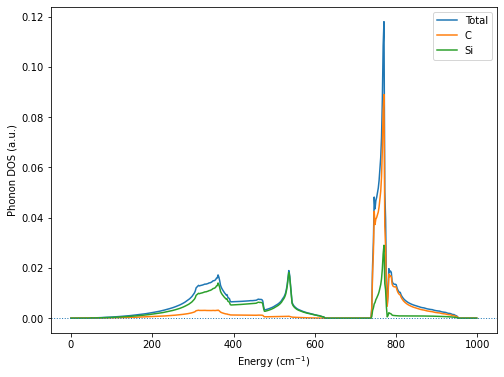

In [23]:
plot(dos[0], dos[1], label='Total')
plot(dos[0], dos[2], label='C')
plot(dos[0], dos[3], label='Si')
xlabel('Energy (cm$^{-1}$)')
ylabel('Phonon DOS (a.u.)')
axhline(ls=':', lw=1)
legend()
savefig('SiC_dos.pdf')

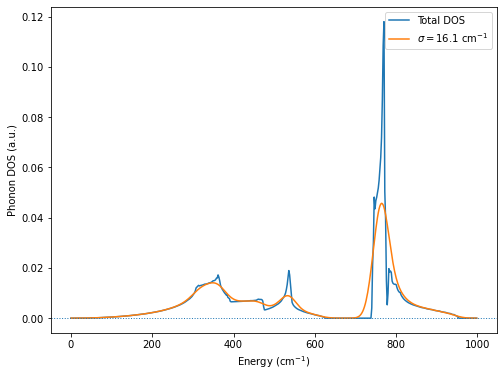

In [24]:
# 2meV sigma
sigma = 2e-3/un.invcm

# middle of the range
x0 = (dos[0,0]+dos[0,-1])/2
# resolution response function
resp = sqrt(2)*exp(-0.5*((dos[0]-x0)/sigma)**2)/(sigma*sqrt(pi))

plot(dos[0], dos[1], label='Total DOS')
plot(dos[0], convolve(dos[1], resp, 'same'), label=f'$\sigma={sigma:.1f}$ cm$^{{-1}}$')

xlabel('Energy (cm$^{-1}$)')
ylabel('Phonon DOS (a.u.)')
axhline(ls=':', lw=1)
legend()
savefig('SiC_dos_conv.pdf')